In [1]:
import os
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import scipy as sp
import seaborn as sns
import xarray as xr

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [19]:
N = 5
K = 30

alpha = 2
P0 = sp.stats.norm
f = lambda x, theta: sp.stats.norm.pdf(x, theta, 0.3)
x_plot = xr.DataArray(np.linspace(-3, 3, 200), dims=["plot"])


In [20]:
beta = sp.stats.beta.rvs(1, alpha, size=(N, K))
w = np.empty_like(beta)
w[:, 0] = beta[:, 0]
w[:, 1:] = beta[:, 1:] * (1 - beta[:, :-1]).cumprod(axis=1)

theta = P0.rvs(size=(N, K))

dpm_pdf_components = f(x_plot, theta[..., np.newaxis])
dpm_pdfs = (w[..., np.newaxis] * dpm_pdf_components).sum(axis=1)

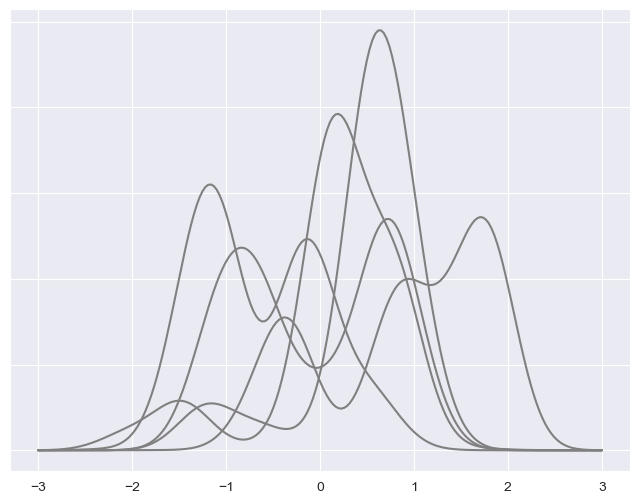

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x_plot, dpm_pdfs.T, c="gray")

ax.set_yticklabels([]);

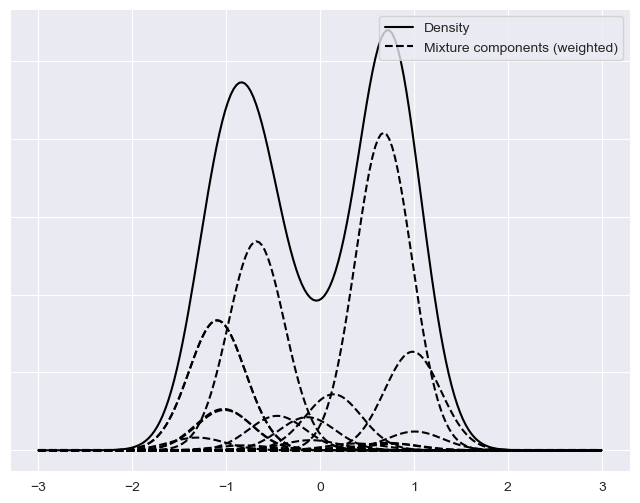

In [22]:
fig, ax = plt.subplots(figsize=(8, 6))

ix = 1

ax.plot(x_plot, dpm_pdfs[ix], c="k", label="Density")
ax.plot(
    x_plot,
    (w[..., np.newaxis] * dpm_pdf_components)[ix, 0],
    "--",
    c="k",
    label="Mixture components (weighted)",
)
ax.plot(x_plot, (w[..., np.newaxis] * dpm_pdf_components)[ix].T, "--", c="k")

ax.set_yticklabels([])
ax.legend(loc=1);

In [6]:
try:
    old_faithful_df = pd.read_csv(os.path.join("..", "data", "old_faithful.csv"))
except FileNotFoundError:
    old_faithful_df = pd.read_csv(pm.get_data("old_faithful.csv"))

In [1]:
old_faithful_df["std_waiting"] = (
    old_faithful_df.waiting - old_faithful_df.waiting.mean()
) / old_faithful_df.waiting.std()

NameError: name 'old_faithful_df' is not defined

In [2]:

old_faithful_df.head()

NameError: name 'old_faithful_df' is not defined

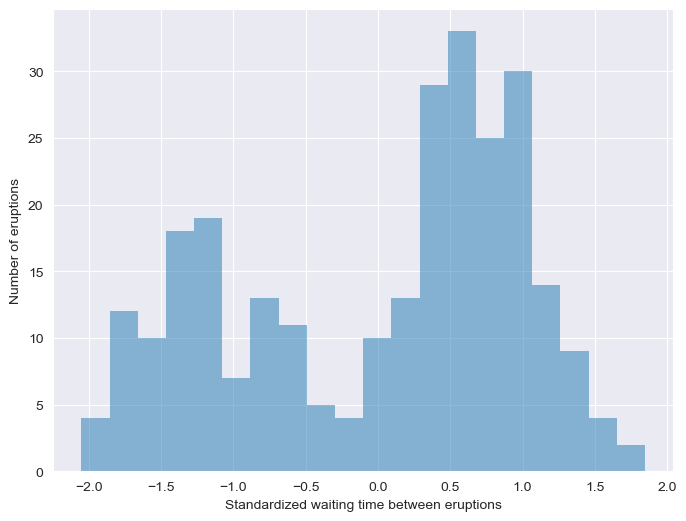

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 20
ax.hist(old_faithful_df.std_waiting, bins=n_bins, color="C0", lw=0, alpha=0.5)

ax.set_xlabel("Standardized waiting time between eruptions")
ax.set_ylabel("Number of eruptions");

# Dirichlet Process Mixture Model

In [10]:
N = old_faithful_df.shape[0]
K = 30

In [11]:
def stick_breaking(beta):
    portion_remaining = pt.concatenate([[1], pt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

In [12]:
with pm.Model(coords={"component": np.arange(K), "obs_id": np.arange(N)}) as model:
    alpha = pm.Gamma("alpha", 1.0, 1.0)
    beta = pm.Beta("beta", 1.0, alpha, dims="component")
    w = pm.Deterministic("w", stick_breaking(beta), dims="component")

    tau = pm.Gamma("tau", 1.0, 1.0, dims="component")
    lambda_ = pm.Gamma("lambda_", 10.0, 1.0, dims="component")
    mu = pm.Normal("mu", 0, tau=lambda_ * tau, dims="component")
    obs = pm.NormalMixture(
        "obs", w, mu, tau=lambda_ * tau, observed=old_faithful_df.std_waiting.values, dims="obs_id"
    )

In [13]:
RANDOM_SEED = 42

with model:
    trace = pm.sample(
        tune=2500,
        init="advi",
        target_accept=0.975,
        random_seed=RANDOM_SEED,
    )

F:\anaconda\envs\pymc_env\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1027: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Auto-assigning NUTS sampler...
Initializing NUTS using advi...


Output()

Convergence achieved at 11000
Interrupted at 10,999 [5%]: Average Loss = 489.13
F:\anaconda\envs\pymc_env\Lib\site-packages\pytensor\tensor\rewriting\elemwise.py:1027: UserWarning: Loop fusion failed because the resulting node would exceed the kernel argument limit.
  warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, tau, lambda_, mu]


Output()

Sampling 4 chains for 2_500 tune and 1_000 draw iterations (10_000 + 4_000 draws total) took 36552 seconds.
There were 102 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


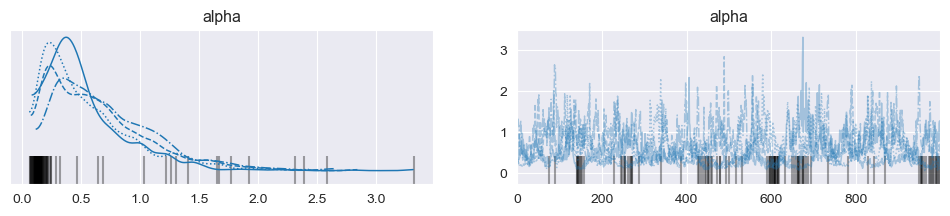

In [14]:
az.plot_trace(trace, var_names=["alpha"]);

# Posterior Predictive Checks

In [15]:
post_pdf_contribs = xr.apply_ufunc(
    sp.stats.norm.pdf,
    x_plot,
    trace.posterior["mu"],
    1.0 / np.sqrt(trace.posterior["lambda_"] * trace.posterior["tau"]),
)

post_pdfs = (trace.posterior["w"] * post_pdf_contribs).sum(dim=("component"))

post_pdf_quantiles = post_pdfs.quantile([0.1, 0.9], dim=("chain", "draw"))

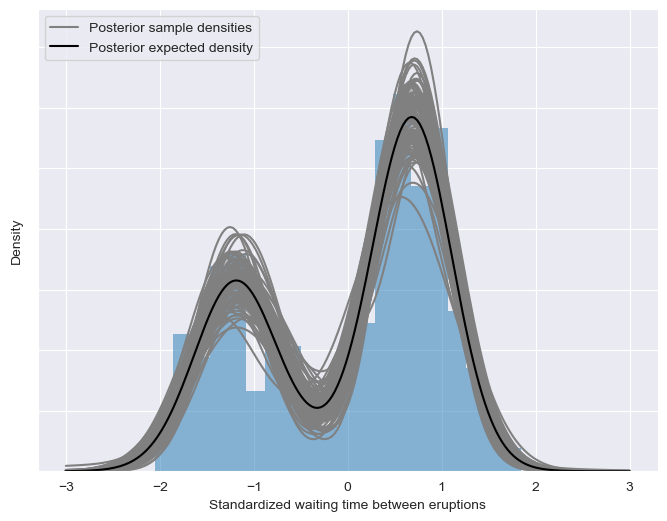

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 20
ax.hist(old_faithful_df.std_waiting.values, bins=n_bins, density=True, color="C0", lw=0, alpha=0.5)

ax.fill_between(
    x_plot,
    post_pdf_quantiles.sel(quantile=0.1),
    post_pdf_quantiles.sel(quantile=0.9),
    color="gray",
    alpha=0.45,
)
ax.plot(x_plot, post_pdfs.sel(chain=0, draw=0), c="gray", label="Posterior sample densities")
ax.plot(
    x_plot,
    az.extract(post_pdfs, var_names="x", num_samples=100),
    c="gray",
)
ax.plot(x_plot, post_pdfs.mean(dim=("chain", "draw")), c="k", label="Posterior expected density")

ax.set_xlabel("Standardized waiting time between eruptions")

ax.set_yticklabels([])
ax.set_ylabel("Density")

ax.legend(loc=2);

In [3]:
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 20
ax.hist(old_faithful_df.std_waiting.values, bins=n_bins, density=True, color="C0", lw=0, alpha=0.5)

ax.plot(x_plot, post_pdfs.mean(dim=("chain", "draw")), c="k", label="Posterior expected density")
ax.plot(
    x_plot,
    (trace.posterior["w"] * post_pdf_contribs).mean(dim=("chain", "draw")).sel(component=0),
    "--",
    c="k",
    label="Posterior expected mixture\ncomponents\n(weighted)",
)
ax.plot(
    x_plot,
    (trace.posterior["w"] * post_pdf_contribs).mean(dim=("chain", "draw")).T,
    "--",
    c="k",
)

ax.set_xlabel("Stimulated Data")

ax.set_yticklabels([])
ax.set_ylabel("Density")

ax.legend(loc=2);

NameError: name 'plt' is not defined